In [1]:
import base

In [2]:
from dataset.sig_dataset import SigDataModule

In [3]:
from model.sig_model import CVAE

In [4]:
from utils import tosig

In [5]:
import os
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib.pyplot as plt
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.progress import TQDMProgressBar

In [6]:
from tqdm import tqdm

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
test = SigDataModule(path=os.path.join(base.data_path,'EURUSD.csv'),batch_size=32,level=4)
test.prepare_data()

In [9]:
#orig_logsig 通过

In [10]:
#test.logsigs 通过

In [11]:
#test.conditions 通过

In [12]:
test.minmax.inverse_transform(test.conditions)

array([[-1.05000000e+00, -1.05000000e+00, -2.83450000e-01, ...,
        -4.78489167e-03,  9.35319875e-03,  5.05704333e-03],
       [-3.50000000e-01, -3.50000000e-01, -2.37315000e+00, ...,
        -1.00759793e+00, -1.72893384e+00, -8.74323445e-01],
       [ 2.00000000e+00,  2.00000000e+00, -5.09180000e+00, ...,
        -1.33404494e+00, -2.79385041e+00, -2.25190530e+00],
       ...,
       [-9.95000000e-01, -9.95000000e-01, -1.34341250e+00, ...,
        -8.48936329e-01, -1.56396035e+00, -7.56394276e-01],
       [ 3.85000000e-01,  3.85000000e-01, -8.05762500e-01, ...,
        -1.30163441e-01, -2.34299056e-01, -1.18854521e-01],
       [ 7.03000000e+00,  7.03000000e+00, -4.01802025e+00, ...,
        -2.91724461e+00, -6.44032373e+00, -3.87201153e+00]])

# plot paths

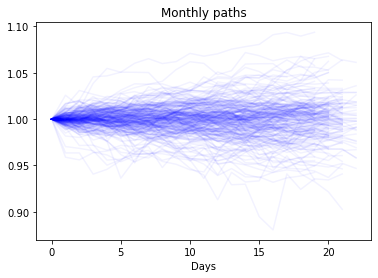

In [13]:
for path in test.windows:
    returns = path[::2, 1] / path[0, 1]
    plt.plot(returns, "b", alpha=0.05)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

# Train model

In [14]:

AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 247
WINDOW_SIZE = 8
LOGGER_PATH = ["local/log", "sig_CVAE"]
MAX_EPOCHS = 10000
level = 4

In [15]:
from model.sig_model import CVAE,MLP
import torch.nn as nn

In [16]:
import torch.nn as nn

In [17]:
input_dim = 8
condition_dim = 8


middle_dim = 50
hidden_dim = 8

In [18]:
common_network = nn.Sequential(
    nn.Linear(input_dim+ condition_dim,middle_dim),
    nn.LeakyReLU(0.3),
)
mean_network = nn.Sequential(
    nn.Linear(middle_dim,hidden_dim),
    nn.LeakyReLU(0.3),
)
logvar_network = nn.Sequential(
    nn.Linear(middle_dim,hidden_dim),
    nn.LeakyReLU(0.3),
)
decode_network = nn.Sequential(
    nn.Linear(hidden_dim+condition_dim,hidden_dim),
    nn.LeakyReLU(0.3),
    nn.Linear(hidden_dim,input_dim),
    nn.Sigmoid(),
)

In [19]:
net = CVAE(common_network, mean_network, logvar_network,decode_network, optim=torch.optim.Adam,lr=0.005)#0.005

INFO:root:struct init
INFO:root:encoder_init_over
INFO:root:decoder_init_over
INFO:root:optim_init_over
INFO:root:struct init_over


In [20]:

dm = SigDataModule(path=os.path.join(base.data_path,'EURUSD.csv'),batch_size=BATCH_SIZE,level=4)
logger = CSVLogger(save_dir=LOGGER_PATH[0], name=LOGGER_PATH[1])
tqdmp = TQDMProgressBar()

In [21]:
trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator='cpu',
    devices=1,
    # auto_select_gpus=True,
    # callbacks = tqdmp,
    # logger=logger,
    # num_nodes=4,
    check_val_every_n_epoch=10,
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [22]:
trainer.fit(net,dm,)


  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 1.7 K 
1 | decoder | Decoder | 208   
------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.007     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5bbde435c0>>
Traceback (most recent call last):
  File "/usr/local/python36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/python36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1295, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


In [23]:
import sys
sys.exit()

SystemExit: 

# evaluation training

# evaluation generate

In [24]:
from tqdm import tqdm

In [25]:
generated = np.array([net.generate(cond).detach().numpy() for cond in dm.conditions])
generated = np.array([dm.minmax.inverse_transform(i.reshape(1,-1))[0] for i in generated])
#generated = MG.generate(MG.conditions[100], n_samples=len(MG.logsigs))
#generated = MG.generate(MG.conditions[150][2] * 0.5, n_samples=len(MG.logsigs))

generated_sigs = np.array([tosig.logsig2sig(logsig, 2, level) for logsig in tqdm(generated)])
real_sigs = np.array([tosig.logsig2sig(logsig, 2, level) for logsig in tqdm(dm.orig_logsig)])

100%|██████████| 248/248 [00:07<00:00, 32.84it/s]


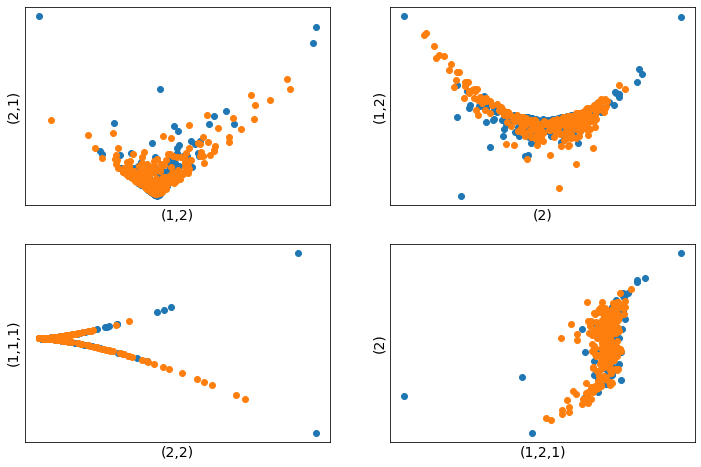

In [26]:
from esig.tosig import sigkeys

keys = sigkeys(2, level).split()

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)

    plt.scatter(real_sigs[:, projection[0]], real_sigs[:, projection[1]],
                label="Real data")
    plt.scatter(generated_sigs[:, projection[0]], generated_sigs[:, projection[1]],
               label="Generated")


    plt.xlabel(keys[projection[0]], fontsize=14)
    plt.ylabel(keys[projection[1]], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    #plt.legend()
    
plt.show()

## Validation: two-sample statistical test

In [28]:
import process_discriminator

normalised_generated = np.array([net.generate(cond).detach().numpy() for cond in dm.conditions])
normalised_generated =  normalised_generated.reshape(-1,8)


sigs1 = np.array([tosig.logsig2sig(logsig, 2, level) for logsig in tqdm(normalised_generated)])
sigs2 = np.array([tosig.logsig2sig(logsig, 2, level) for logsig in tqdm(dm.logsigs)])

res = process_discriminator.test(sigs1, sigs2, order=level, compute_sigs=False,
                                 confidence_level=0.99)

print("Are the generated and real distributions DIFFERENT? {}".format(res))

100%|██████████| 247/247 [00:07<00:00, 32.84it/s]


Computing signatures of population 1:   0%|          | 0/247 [00:00<?, ?it/s]

Computing signatures of population 2:   0%|          | 0/247 [00:00<?, ?it/s]

Are the generated and real distributions DIFFERENT? False


## Invert log-signature

In [ ]:
def prinfo(a):
    try:
        print('__len:',len(a))
    except:
        pass
    try:
        print('_type:',type(a))
    except:
        pass
    try:
        print('shape:',a.shape)
    except:
        pass
    return a

In [ ]:
import logsig_inversion
from esig.tosig import stream2logsig
from utils.leadlag import leadlag

logsig = net.generate(dm.conditions[0])
logsig = dm.minmax.inverse_transform(logsig.detach().numpy())

In [ ]:
prinfo(logsig)

In [ ]:
%%time
pip = 0.0001 #0.01
n_pips = 5 * 10000
n_points = 21#21

n_iterations = 100 #循环次数
n_organisms = 400 #生物  

recovered_path, loss = logsig_inversion.train(logsig, level, n_iterations, n_organisms, n_points,
                                              pip, n_pips)

In [ ]:
plt.plot(recovered_path)
plt.show()
print(f"Target log-signature: {logsig.tolist()}")
print(f"Recovered log-signature: {stream2logsig(leadlag(recovered_path), level).tolist()}")

In [ ]:
paths = []
for condition in tqdm(dm.conditions):
    logsig = net.generate(condition)
    logsig = dm.minmax.inverse_transform(logsig.detach().numpy())
    recovered_path, loss = logsig_inversion.train(logsig, level, n_iterations, n_organisms, n_points,
                                                  pip, n_pips)
    
    paths.append(recovered_path)

In [ ]:
import matplotlib.patches as mpatches

plt.figure(figsize=(8, 6))
for path1, path2 in zip(paths, dm.windows):
    returns = path2[::2, 1][:20] - path2[0, 1]
    plt.plot(returns, "C1", alpha=0.25)

    plt.plot(path1[:20], "C0", alpha=0.25)
    
    
blue_patch = mpatches.Patch(color='C0', label='Generated paths')
red_patch = mpatches.Patch(color='C1', label='Real paths')
plt.legend(handles=[blue_patch, red_patch], fontsize=12)    
plt.xlabel("Days", fontsize=14) 
plt.show()

In [27]:
# trainer.save_checkpoint('EURUSDvbest_21.ckpt')

In [ ]:
## v2 扩大化, 1缩小化

In [ ]:
returns1 = [path[-1] - path[0] for path in paths]
returns2 = [path[-1, 1] - path[0, 0] for path in dm.windows]

_ = plt.hist([returns1, returns2], bins=20, label=["Real paths", "Generated paths"])
plt.xlabel("Monthly return", fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [ ]:
from utils.leadlag import leadlag

In [ ]:
def concatenate(condition, periods):#periods 期 一单元是一个月 所以3期就是 3*1 = 3个月
    joined_path = None

    for _ in range(periods):
        generated = net.generate(condition)
        generated = dm.minmax.inverse_transform(generated.detach().numpy())
        path, loss = logsig_inversion.train(generated, level, n_iterations, n_organisms, n_points,#window
                                            pip, n_pips)

        condition = tosig.stream2logsig(leadlag(recovered_path), level)
        condition = dm.minmax.transform([condition])[0]

        if joined_path is None:
            joined_path = path
        else:
            joined_path = np.r_[joined_path, np.add(path[1:], joined_path[-1])]#!
            
    return joined_path

In [ ]:
idx = 195 #从第几天开始模拟 找到当天对应的id
#  低波动率
condition = dm.conditions[idx]

paths = [concatenate(condition, 1) for _ in range(40)]# 条数 生成几条数据

plt.plot(np.transpose(paths))
plt.show()

In [ ]:
plt.plot(dm.windows[idx + 1][0, 0] + np.transpose(paths))
plt.plot(dm.windows_values[idx + 1],'bo')
plt.xlabel("Days", fontsize=14) 
plt.show()#